# **Install dan Import**

In [1]:
!pip install pandas matplotlib seaborn requests scikit-learn ibm-watsonx-ai langchain_community replicate

In [2]:
!pip install xgboost lightgbm catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from langchain_community.llms import Replicate
from langchain.callbacks.base import BaseCallbackHandler

from google.colab import userdata

# **Set The API Token**

In [4]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.2-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

# **Load Dataset**

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/drug-labels-and-side-effects-dataset-1400-records")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/drug-labels-and-side-effects-dataset-1400-records


In [10]:
data = pd.read_csv("/kaggle/input/drug-labels-and-side-effects-dataset-1400-records/realistic_drug_labels_side_effects.csv")
data.head()

,drug_name,manufacturer,approval_year,drug_class,indications,side_effects,dosage_mg,administration_route,contraindications,warnings,price_usd,batch_number,expiry_date,side_effect_severity,approval_status
0,Seroxetine50,AstraZeneca,1996,Antidepressant,Allergy relief,"Fatigue, Nausea",260,Rectal,Bleeding disorders,Avoid alcohol,192.43,MV388Pl,2026-11-29,Mild,Pending
1,Mecoparin93,AstraZeneca,2018,Vaccine,Allergy relief,Nausea,470,Inhalation,Allergic reaction,Take with food,397.82,UR279ZN,2027-07-14,Mild,Approved
2,Daxozole89,Merck & Co.,1997,Antipsychotic,Allergy relief,"Diarrhea, Blurred vision, Dizziness",330,Sublingual,High blood pressure,Take with food,131.69,we040kH,2028-06-02,Moderate,Pending
3,Viracillin84,Roche Holding AG,2004,Antifungal,Inflammation reduction,"Fatigue, Dry mouth",450,Oral,Kidney impairment,Do not operate machinery,372.82,hO060rh,2026-07-07,Mild,Rejected
4,Amoxstatin62,Pfizer Inc.,2003,Antidepressant,Psychosis control,"Insomnia, Dry mouth, Fatigue",430,Topical,Bleeding disorders,Do not operate machinery,281.48,Fa621Sw,2027-12-28,Moderate,Pending


# **EDA (Exploratory Data Analysis)**

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   drug_name             1436 non-null   object 
 1   manufacturer          1436 non-null   object 
 2   approval_year         1436 non-null   int64  
 3   drug_class            1436 non-null   object 
 4   indications           1436 non-null   object 
 5   side_effects          1436 non-null   object 
 6   dosage_mg             1436 non-null   int64  
 7   administration_route  1436 non-null   object 
 8   contraindications     1436 non-null   object 
 9   warnings              1436 non-null   object 
 10  price_usd             1436 non-null   float64
 11  batch_number          1436 non-null   object 
 12  expiry_date           1436 non-null   object 
 13  side_effect_severity  1436 non-null   object 
 14  approval_status       1436 non-null   object 
dtypes: float64(1), int64(

In [12]:
data.isnull().sum()

,0
drug_name,0
manufacturer,0
approval_year,0
drug_class,0
indications,0
side_effects,0
dosage_mg,0
administration_route,0
contraindications,0
warnings,0


In [13]:
print("Data Duplicate:", data.duplicated().sum())

Data Duplicate: 0


In [14]:
data.describe()

,approval_year,dosage_mg,price_usd
count,1436.000000,1436.000000,1436.000000
mean,2006.860028,509.637883,251.844854
std,10.167067,286.417268,142.640781
min,1990.000000,10.000000,1.210000
25%,1998.000000,270.000000,128.830000
50%,2007.000000,515.000000,255.130000
75%,2016.000000,760.000000,372.207500
max,2024.000000,990.000000,499.060000


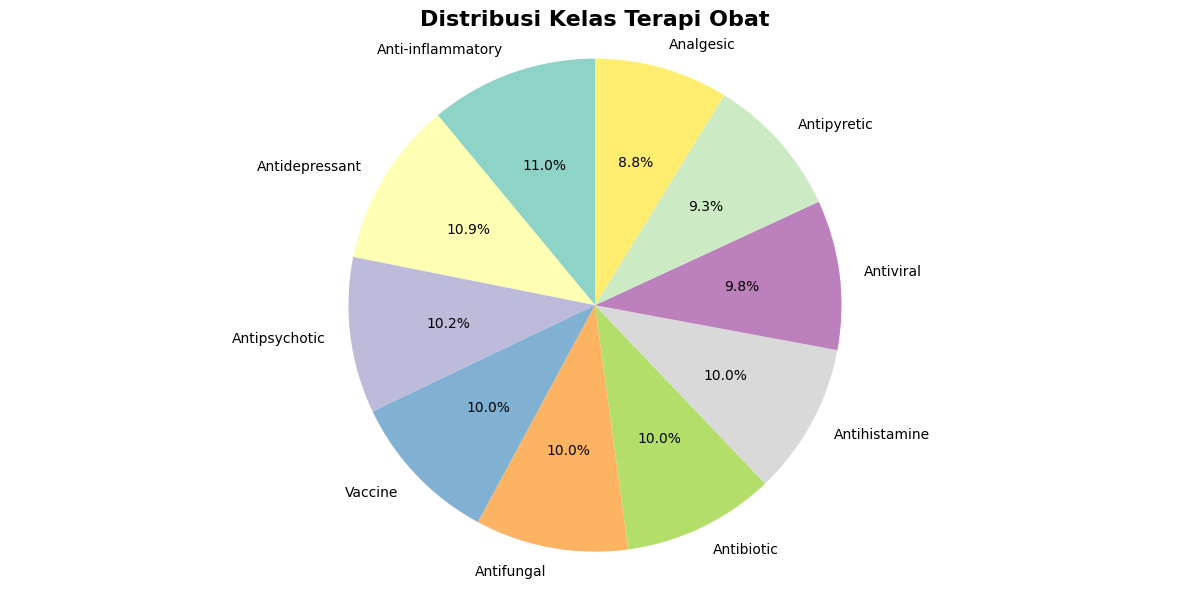

In [15]:
plt.figure(figsize=(12, 6))
drug_class_counts = data['drug_class'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(drug_class_counts)))
plt.pie(drug_class_counts.values, labels=drug_class_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribusi Kelas Terapi Obat', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

Insight: Dari pie chart di atas diketahui bahwa distribusi konsumsi obat terbanyak terdapat pada kelas terapi obat Anti-Inflamatory (Anti Inflamasi). Kemudian, diikuti oleh Antidepresant (antidepresi), Antipsychotic (antipsikotik), dsb.

/tmp/ipython-input-2599476656.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='manufacturer', y='price_usd', palette='viridis')


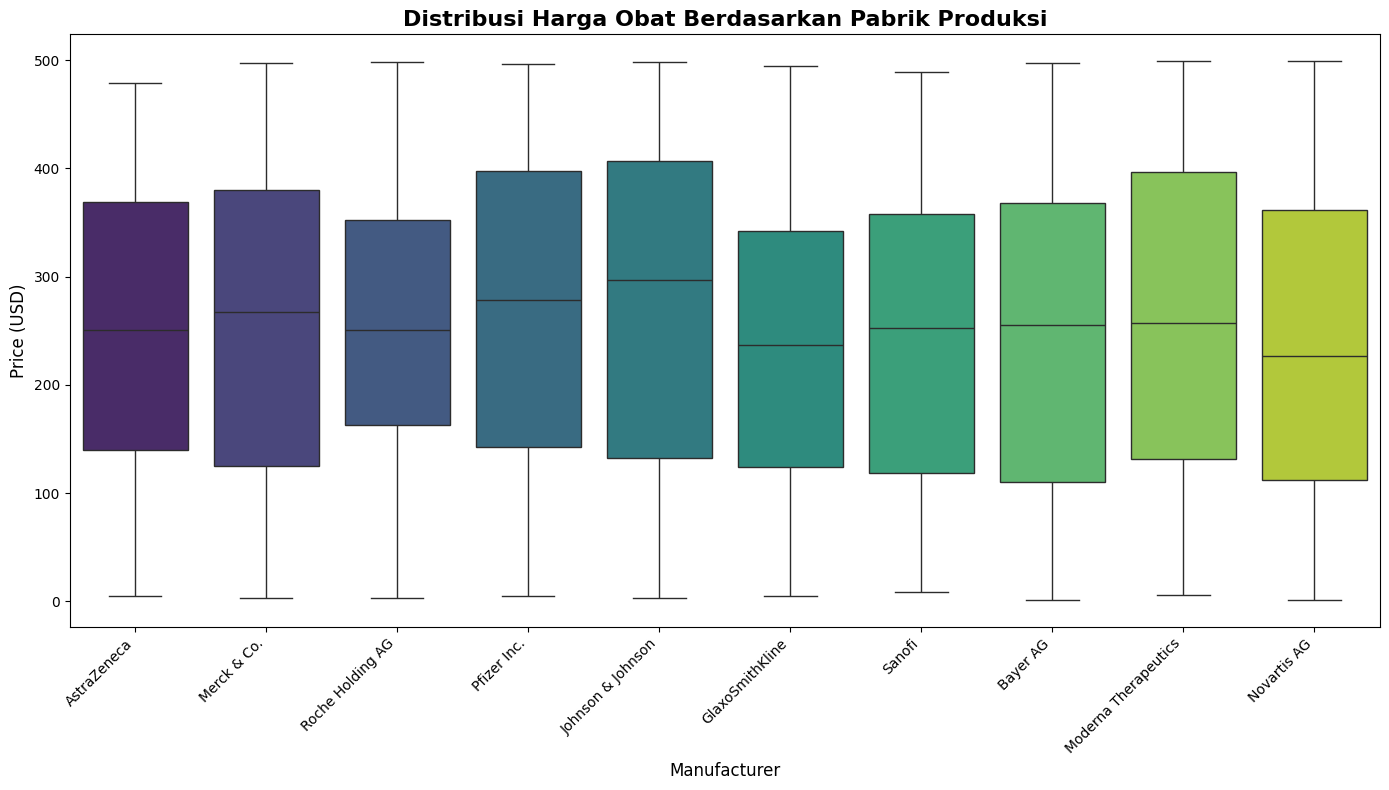

In [16]:
# Harga vs drug_class

plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='manufacturer', y='price_usd', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Harga Obat Berdasarkan Pabrik Produksi', fontsize=16, fontweight='bold')
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.tight_layout()
plt.show()

Insight: Perbedaan harga terjadi di antara produsen (pabrik), dengan beberapa produsen menunjukkan rentang harga yang lebih luas, menunjukkan strategi penetapan harga dan portofolio produk yang berbeda-beda yang memengaruhi posisi pasar dan aksesibilitas.

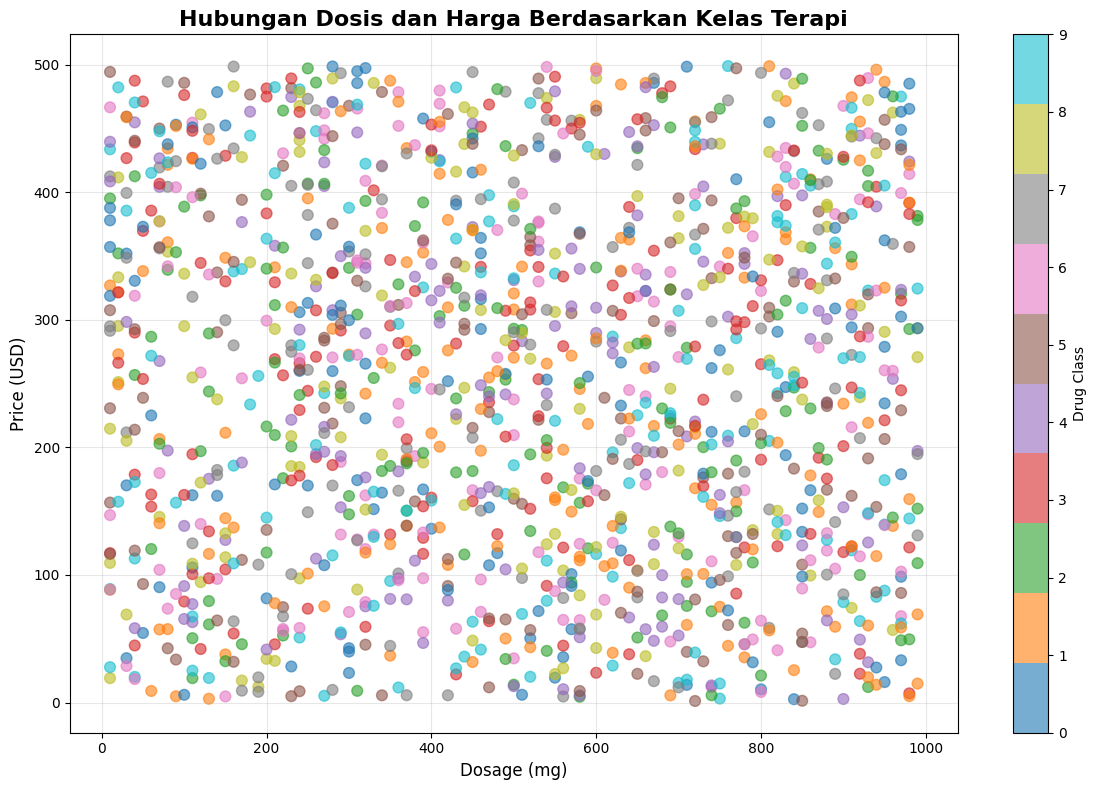

In [17]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['dosage_mg'], data['price_usd'],
                     c=data['drug_class'].astype('category').cat.codes,
                     cmap='tab10', alpha=0.6, s=60)
plt.xlabel('Dosage (mg)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Hubungan Dosis dan Harga Berdasarkan Kelas Terapi', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Drug Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Insight: Tidak terdapat korelasi linier yang kuat antara dosis dan harga obat, hal ini menunjukkan bahwa penetapan harga lebih bergantung pada kompleksitas obat, biaya penelitian, dan faktor pasar.

<Figure size 1000x600 with 0 Axes>

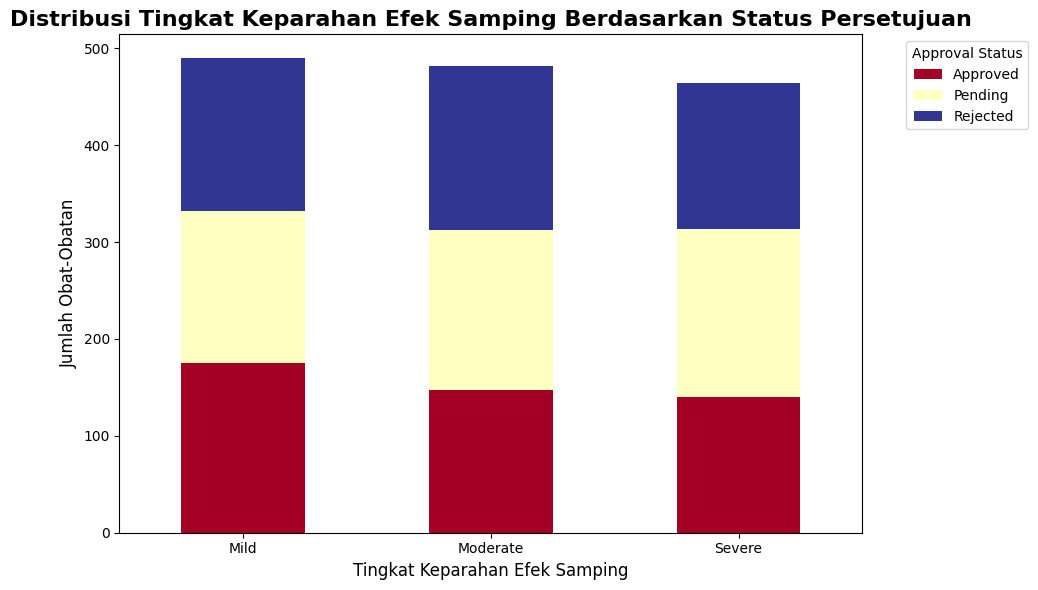

In [18]:
plt.figure(figsize=(10, 6))
severity_approval = pd.crosstab(data['side_effect_severity'], data['approval_status'])
severity_approval.plot(kind='bar', stacked=True, colormap='RdYlBu', figsize=(10, 6))
plt.title('Distribusi Tingkat Keparahan Efek Samping Berdasarkan Status Persetujuan', fontsize=16, fontweight='bold')
plt.xlabel('Tingkat Keparahan Efek Samping', fontsize=12)
plt.ylabel('Jumlah Obat-Obatan', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Approval Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Insight: Grafik di atas menunjukkan tingkat keparahan efek samping yang dikelompokkan menjadi 3 tingkat yaitu Mild (ringan), Moderate (sedang), dan Severe (Parah) berdasarkan status persetujuan yang dikelompokkan menjadi 3 kategori yaitu Approved (Disetujui), Pending (Menunggu), dan Rejected (Ditolak). Dari grafik tersebut bisa diketahui bahwa obat-obatan dengan status disetujui dan memiliki tingkat efek samping yang parah lebih sedikit, sementara obat-obatan dengan status pending (proses persetujuan) di semua tingkat keparahan memiliki angka lebih tinggi.


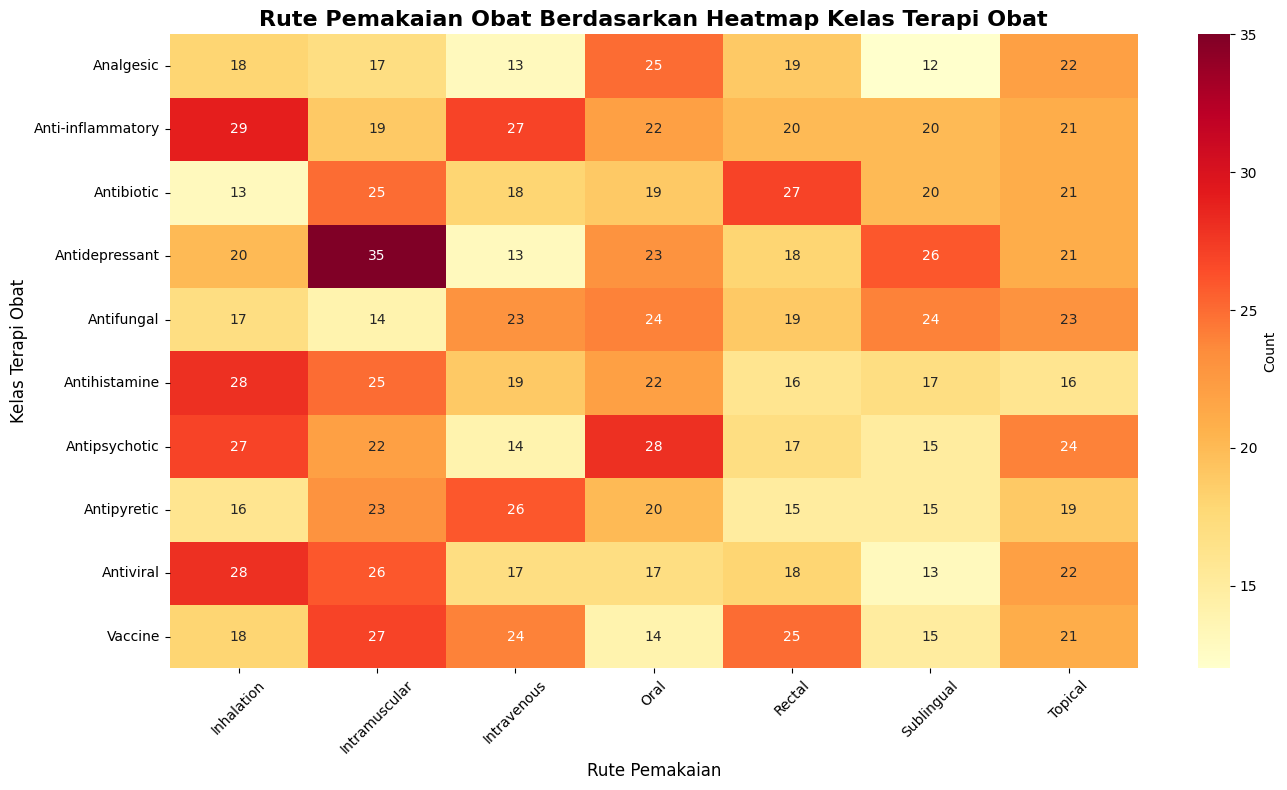

In [19]:
plt.figure(figsize=(14, 8))
admin_class = pd.crosstab(data['drug_class'], data['administration_route'])
sns.heatmap(admin_class, annot=True, cmap='YlOrRd', fmt='d', cbar_kws={'label': 'Count'})
plt.title('Rute Pemakaian Obat Berdasarkan Heatmap Kelas Terapi Obat', fontsize=16, fontweight='bold')
plt.xlabel('Rute Pemakaian', fontsize=12)
plt.ylabel('Kelas Terapi Obat', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Insight: Heatmap di atas menunjukkan bahwa rute pemakaian **Intramuscular** -- *yaitu pemberian obat atau zat melalui injeksi langsung ke dalam otot*, banyak digunakan pada kelas terapi obat **Antidepresant**.

<Figure size 1400x600 with 0 Axes>

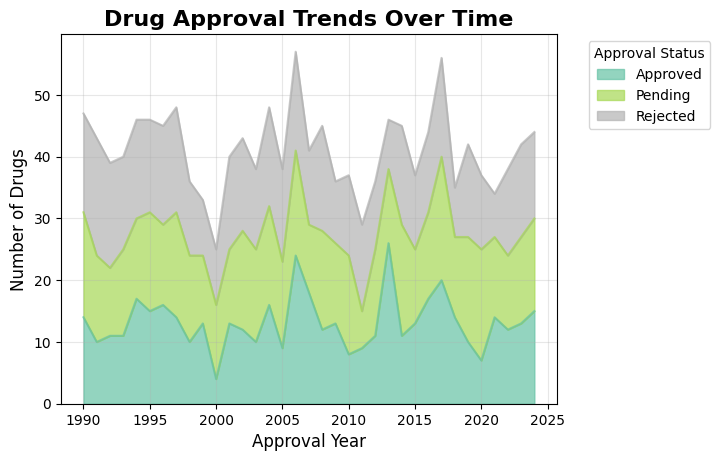

In [20]:
plt.figure(figsize=(14,6))
approval_timeline = data.groupby(['approval_year', 'approval_status']).size().unstack(fill_value=0)
approval_timeline.plot(kind='area', stacked=True, alpha=0.7, colormap='Set2')
plt.title('Drug Approval Trends Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Approval Year', fontsize=12)
plt.ylabel('Number of Drugs', fontsize=12)
plt.legend(title='Approval Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

Insight: Pengembangan obat menunjukkan pola siklikal, dengan tahun-tahun terakhir mencatat lebih banyak permohonan persetujuan yang tertunda, kemungkinan mencerminkan peningkatan pengawasan regulasi dan proses persetujuan yang lebih lama.

<Figure size 1200x800 with 0 Axes>

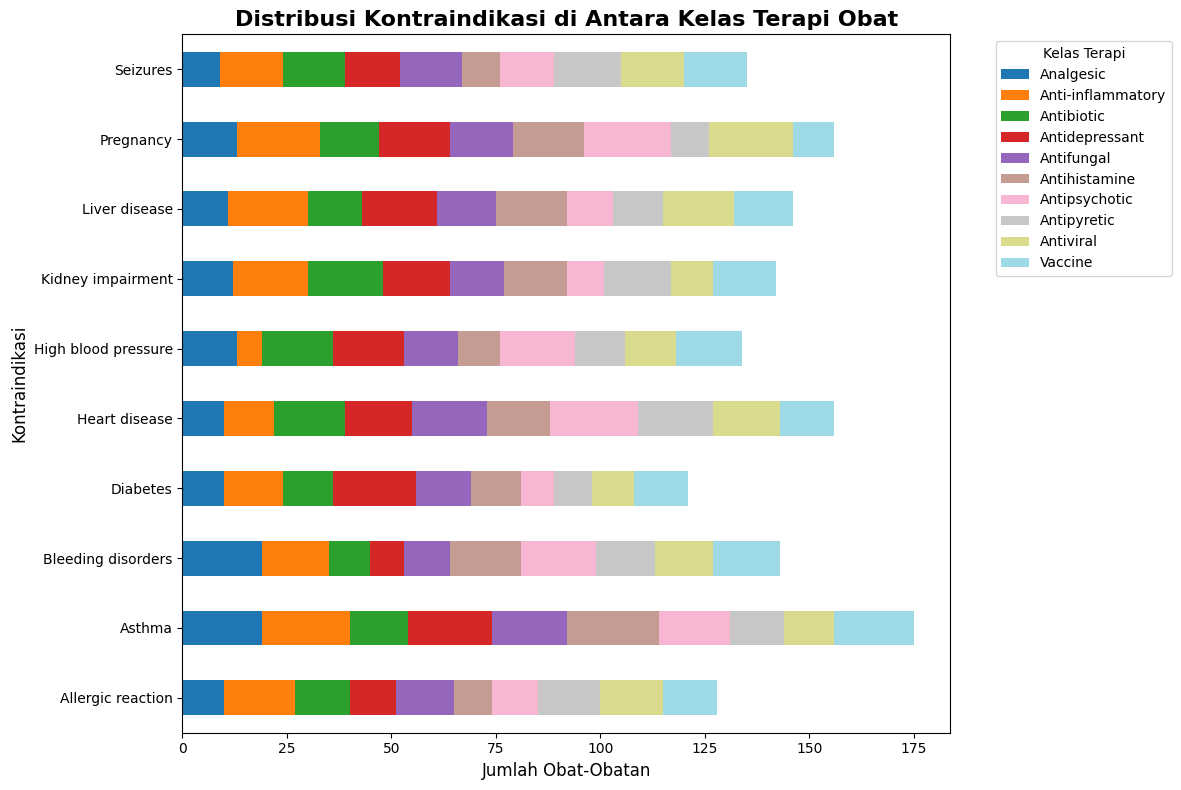

In [21]:
plt.figure(figsize=(12, 8))
contra_class = pd.crosstab(data['contraindications'], data['drug_class'])
contra_class.plot(kind='barh', stacked=True, colormap='tab20', figsize=(12, 8))
plt.title('Distribusi Kontraindikasi di Antara Kelas Terapi Obat', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah Obat-Obatan', fontsize=12)
plt.ylabel('Kontraindikasi', fontsize=12)
plt.legend(title='Kelas Terapi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Insight: Grafik di atas menunjukkan bahwa Penyakit Asma dan kehamilan merupakan kontraindikasi yang paling umum, dengan kelas terapi obat yang berbeda menunjukkan profil keamanan yang bervariasi sesuai dengan mekanisme aksi mereka.

/tmp/ipython-input-380772567.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sorted, x='administration_route', y='dosage_mg', palette='muted')


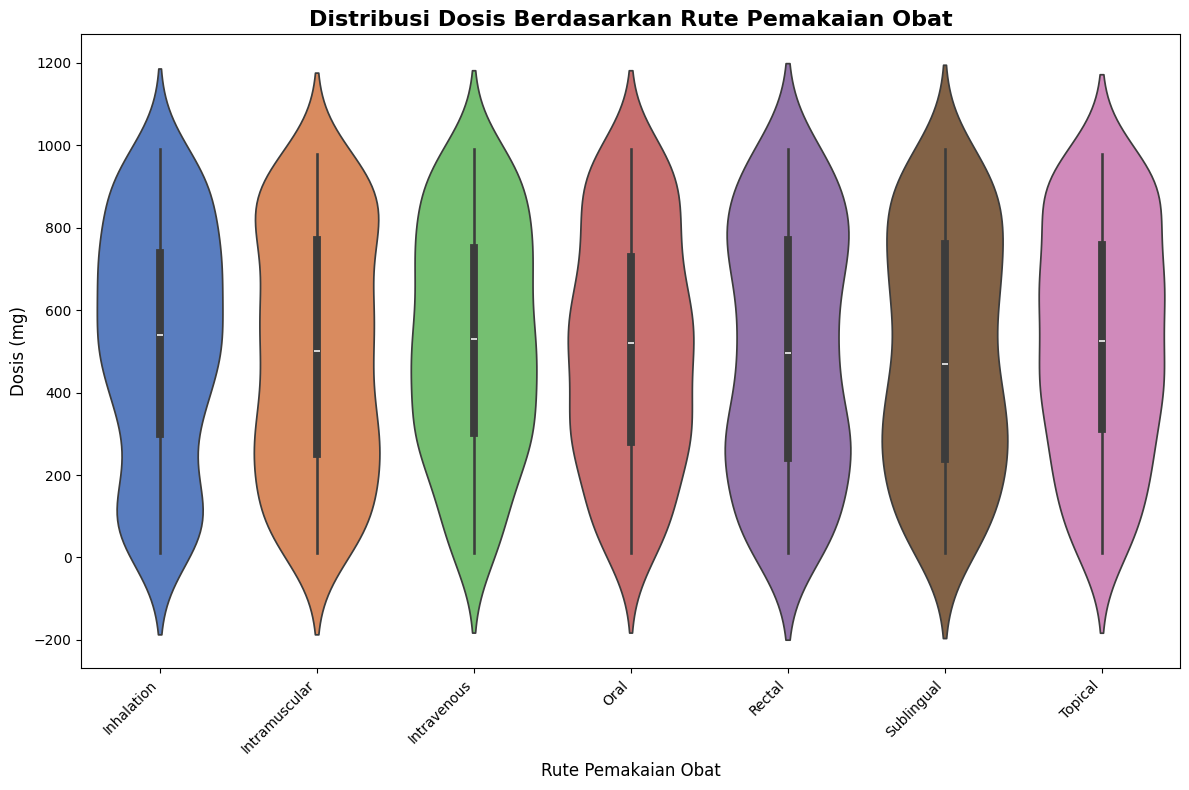

In [22]:
plt.figure(figsize=(12, 8))
df_sorted = data.sort_values('administration_route')
sns.violinplot(data=df_sorted, x='administration_route', y='dosage_mg', palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Dosis Berdasarkan Rute Pemakaian Obat', fontsize=16, fontweight='bold')
plt.xlabel('Rute Pemakaian Obat', fontsize=12)
plt.ylabel('Dosis (mg)', fontsize=12)
plt.tight_layout()
plt.show()

Insight: Rute pemakaian oral (dari mulut) dan intramuskular (ke dalam jaringan otot) menunjukkan rentang dosis yang lebih luas, sementara aplikasi topikal cenderung menggunakan dosis yang lebih rendah, mencerminkan perbedaan bioavailabilitas dan penyerapan.

/tmp/ipython-input-4037447500.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=severity_data, x='drug_class', y='price_usd',
/tmp/ipython-input-4037447500.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity_data, x='drug_class', y='price_usd',
/tmp/ipython-input-4037447500.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=severity_data, x='drug_class', y='price_usd',
/tmp/ipython-input-4037447500.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity_data, x='drug_class', y='price_usd',
/tmp/ipython-input-4037447500.py:6: FutureWa

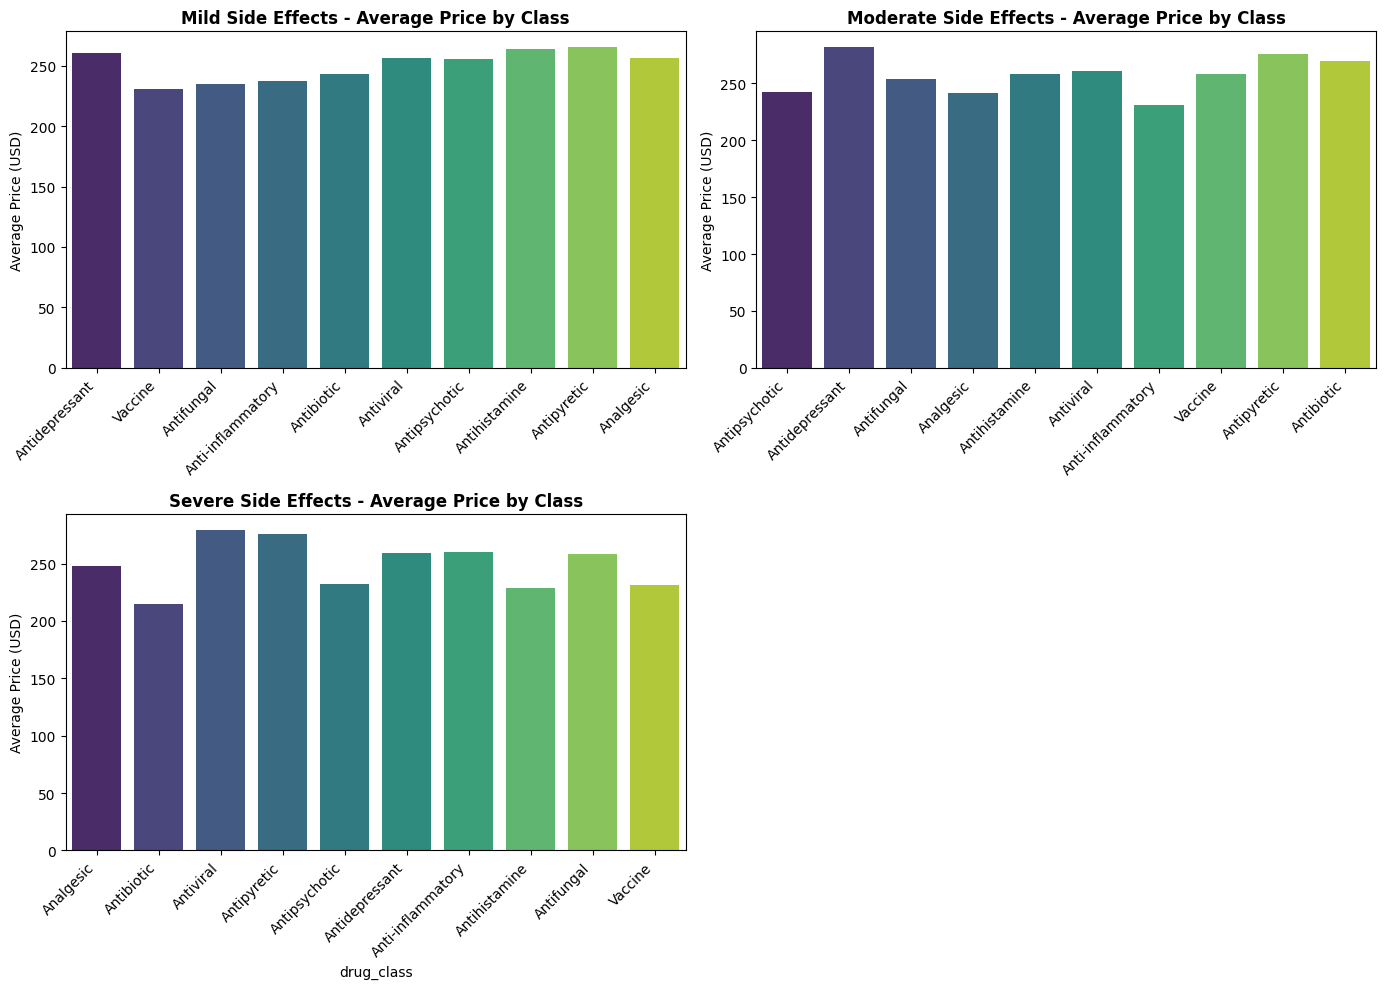

In [23]:
plt.figure(figsize=(14, 10))
severity_order = ['Mild', 'Moderate', 'Severe']
for i, severity in enumerate(severity_order):
    plt.subplot(2, 2, i+1)
    severity_data = data[data['side_effect_severity'] == severity]
    sns.barplot(data=severity_data, x='drug_class', y='price_usd',
                palette='viridis', ci=None)
    plt.title(f'{severity} Side Effects - Average Price by Class', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Price (USD)')
    if i < 2:
        plt.xlabel('')

plt.tight_layout()
plt.show()

Insight: Obat-obatan dengan efek samping serius/parah menunjukkan variasi harga yang lebih besar antar kelas, sementara obat-obatan dengan efek samping ringan mempertahankan pola harga yang lebih konsisten di dalam kelasnya.

/tmp/ipython-input-235909024.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=indication_counts.values, y=indication_counts.index, palette='coolwarm')


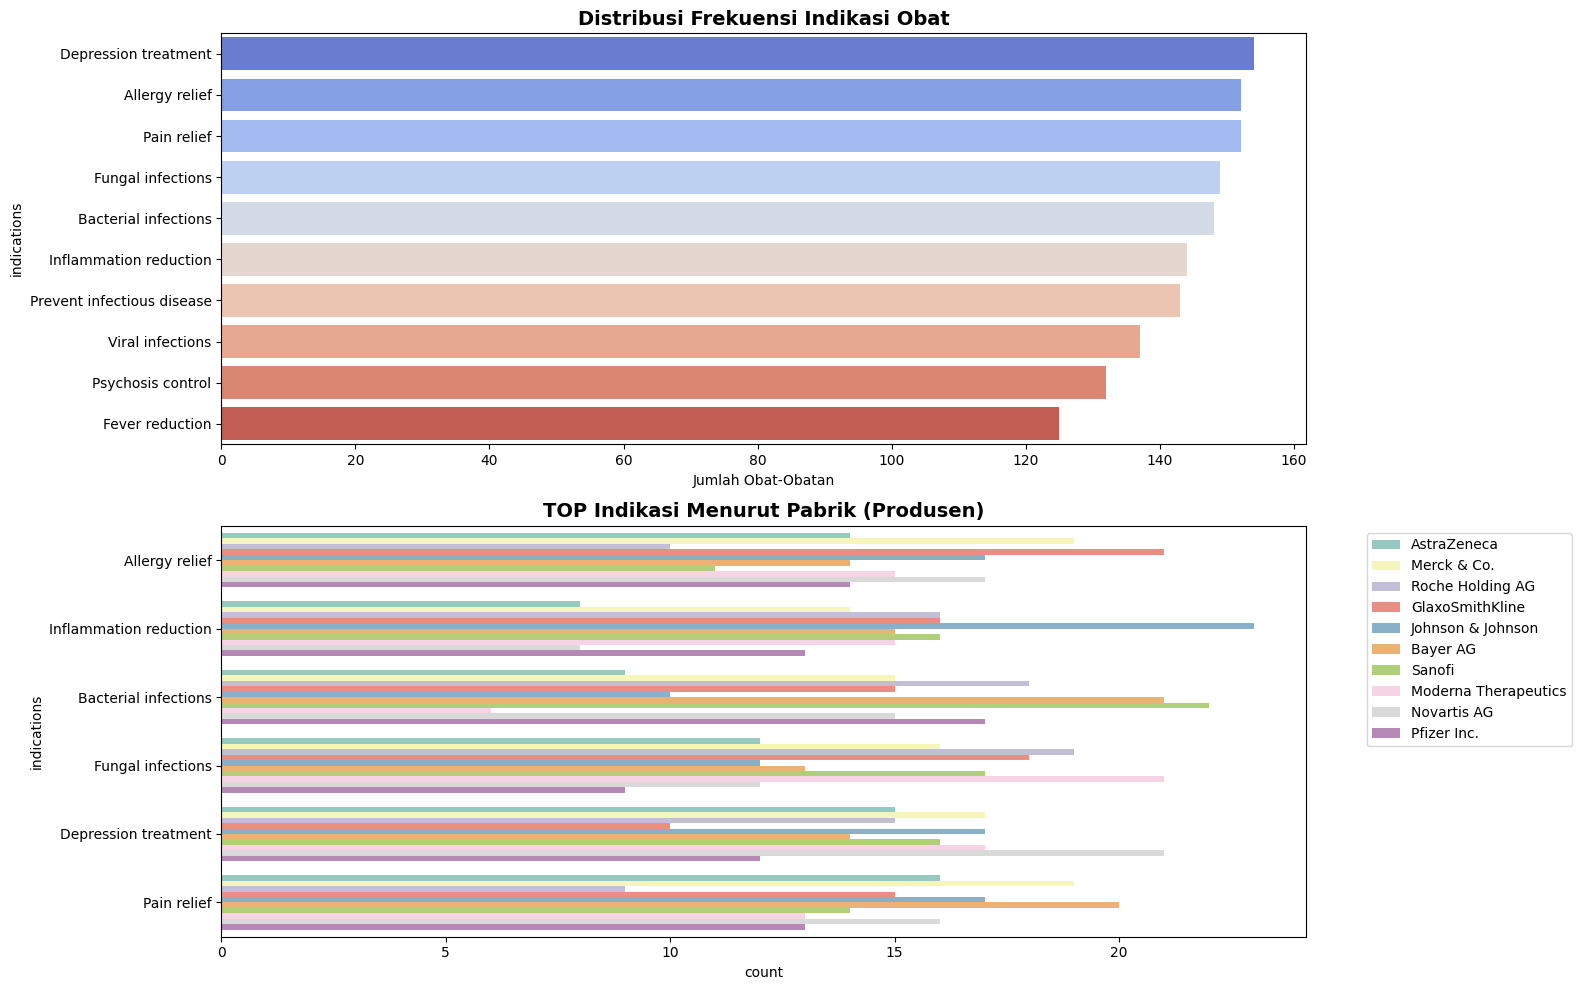

In [24]:
plt.figure(figsize=(16, 10))
indication_approval = data.groupby(['indications', 'manufacturer', 'approval_status']).size().unstack(fill_value=0)
approved_ratio = indication_approval['Approved'] / (indication_approval['Approved'] + indication_approval['Pending'] + indication_approval.get('Rejected', 0))

plt.subplot(2, 1, 1)
indication_counts = data['indications'].value_counts()
sns.barplot(x=indication_counts.values, y=indication_counts.index, palette='coolwarm')
plt.title('Distribusi Frekuensi Indikasi Obat', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Obat-Obatan')

plt.subplot(2, 1, 2)
top_indications = data['indications'].value_counts().head(6).index
filtered_df = data[data['indications'].isin(top_indications)]
sns.countplot(data=filtered_df, y='indications', hue='manufacturer', palette='Set3')
plt.title('TOP Indikasi Menurut Pabrik (Produsen)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Insight:

Grafik di atas memberikan dua informasi, yaitu:
1. Grafik "Distribusi Frekuensi Indikasi Obat" menunjukkan bahwa obat dengan indikasi "Depression treatrment (pengobatan depresi)" sangat banyak dikonsumsi.
2. Grafik "TOP Indikasi Menurut Pabrik (Produsen)" menunjukkan bahwa Pabrik Johnson & Johnson paling banyak diminati untuk indikasi "Inflammation reduction (pengobatan peradangan)".

# **Preprocessing Data & Feature Engineering**

In [25]:
categorical_cols = ['drug_class', 'manufacturer', 'side_effect_severity']
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

data['side_effect_count'] = data['side_effects'].apply(lambda x: len(str(x).split(',')))

# Drop non-numeric columns before splitting
non_numeric_cols_to_drop = ['drug_name', 'indications', 'side_effects', 'administration_route', 'contraindications', 'warnings', 'batch_number', 'expiry_date']
data_processed = data.drop(columns=non_numeric_cols_to_drop)

target_col = 'approval_status'  # Target prediksi
# Apply Label Encoding to the target variable
data_processed[target_col] = LabelEncoder().fit_transform(data_processed[target_col].astype(str))

X = data_processed.drop(columns=[target_col])
y = data_processed[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data training dan testing siap untuk model training.")

Data training dan testing siap untuk model training.


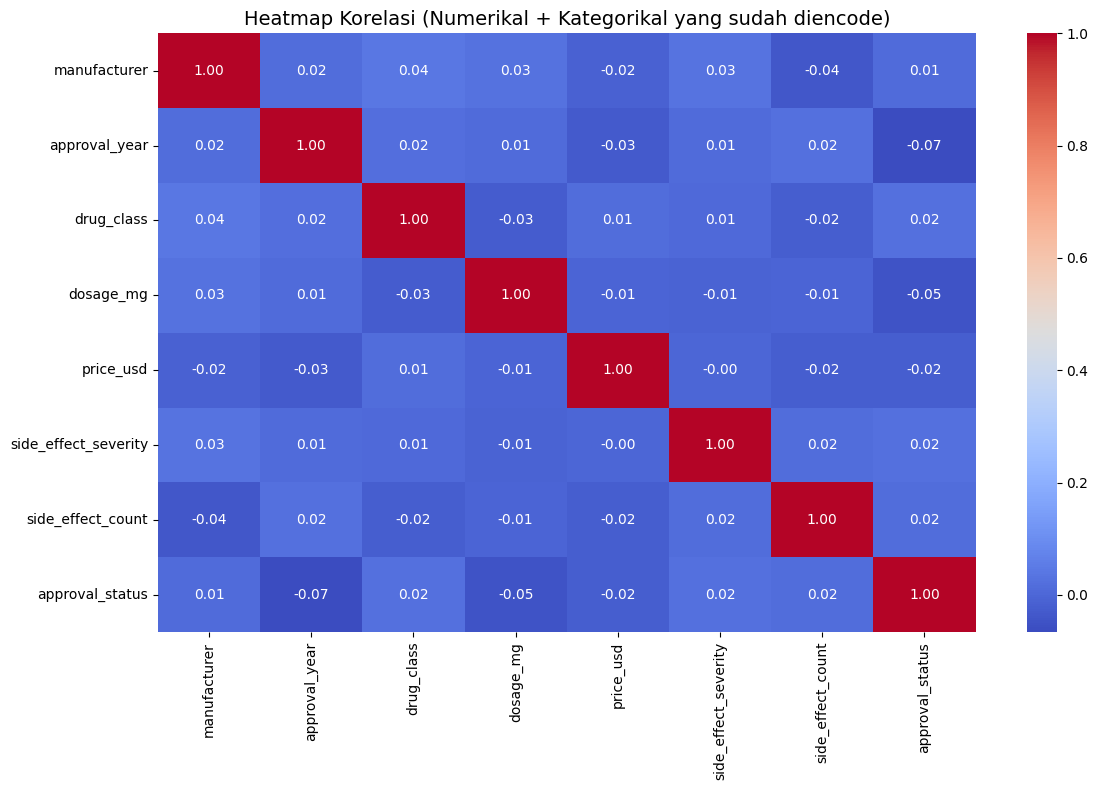

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gabungkan kembali X dan y untuk analisis korelasi
train_data = X_train.copy()
train_data[target_col] = y_train

# Hitung matriks korelasi
corr_matrix = train_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

plt.title("Heatmap Korelasi (Numerikal + Kategorikal yang sudah diencode)", fontsize=14)
plt.tight_layout()
plt.show()

# **Train Model Di WatsonX AutoAI (Granite Tabular)**

In [27]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(multi_class='multinomial', max_iter=1000),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

results = []
reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="macro")
    results.append((name, f1))
    reports[name] = classification_report(y_test, y_pred, digits=2)
    print(f"\n=== {name} ===")
    print(reports[name])


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.29      0.24      0.26        91
           1       0.39      0.37      0.38       105
           2       0.29      0.35      0.32        92

    accuracy                           0.32       288
   macro avg       0.32      0.32      0.32       288
weighted avg       0.32      0.32      0.32       288


=== GradientBoosting ===
              precision    recall  f1-score   support

           0       0.35      0.35      0.35        91
           1       0.44      0.43      0.43       105
           2       0.39      0.40      0.40        92

    accuracy                           0.40       288
   macro avg       0.39      0.39      0.39       288
weighted avg       0.40      0.40      0.40       288



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.34      0.25      0.29        91
           1       0.36      0.34      0.35       105
           2       0.33      0.43      0.38        92

    accuracy                           0.34       288
   macro avg       0.34      0.34      0.34       288
weighted avg       0.34      0.34      0.34       288


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.29      0.27      0.28        91
           1       0.39      0.42      0.40       105
           2       0.29      0.28      0.29        92

    accuracy                           0.33       288
   macro avg       0.32      0.33      0.32       288
weighted avg       0.33      0.33      0.33       288

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

In [28]:
# Memilih model terbaik
best_model_name, best_f1 = sorted(results, key=lambda x: x[1], reverse=True)[0]
best_model = models[best_model_name]
print(f"\nModel terbaik: {best_model_name} | Macro F1-score = {best_f1:.4f}")


Model terbaik: GradientBoosting | Macro F1-score = 0.3941


 # **Setup IBM Granite via Replicate (Streaming)**

In [37]:
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
model = "ibm-granite/granite-3.2-8b-instruct"

class StreamHandler(BaseCallbackHandler):
    def __init__(self):
        self.text = ""
    def on_llm_new_token(self, token: str, **kwargs):
        self.text += token
        print(token, end="")

handler = StreamHandler()
llm_stream = Replicate(
    model=model,
    replicate_api_token=api_token,
    streaming=True,
    callbacks=[handler]
)

# Calculate and format top side effects
side_effects_list = data['side_effects'].str.split(', ').explode()
side_effect_counts = side_effects_list.value_counts().head(10) # Get top 10 side effects
side_top_text = "\n".join([f"- {effect}: {count}" for effect, count in side_effect_counts.items()])

# Gabungan prompt untuk Granite
prompt_combined = f"""
=== Bagian 1: Analisis Approval Status ===
Saya memiliki dataset obat dengan fitur: {list(X.columns)}.
Hasil model prediksi approval status menggunakan {best_model_name}:
{reports[best_model_name]}

Tolong analisis faktor-faktor penting yang mempengaruhi approval status,
serta berikan rekomendasi strategis yang dapat diambil perusahaan farmasi.

=== Bagian 2: Analisis Efek Samping ===
Konteks: Dataset ini memiliki sekitar {len(data)} record.
Kolom penting: {', '.join(list(X.columns)[:30])}.

Top efek samping teratas (nama dan frekuensi):
{side_top_text}

Berikan analisis menyeluruh:
1) Kelompok efek samping mana yang paling berbahaya atau perlu pemantauan lebih lanjut, serta alasan.
2) Saran metrik atau studi farmakovigilans yang perusahaan harus jalankan untuk mendeteksi efek samping ini lebih awal.
3) Rekomendasi komunikasi risiko kepada regulator dan pasien.
4) Bila ada, kaitkan pola efek samping ke fitur lain yang relevan (misalnya drug_class, dosage, manufacturer).

Output yang diharapkan:
(a) Ringkasan temuan.
(b) Rekomendasi 3–5 poin.
(c) Usulan eksperimen atau validasi yang dapat dilakukan.
"""

# Kirim ke Granite via Replicate
print("\n\n--- Granite Full Combined Insight ---\n")
granite_output_combined = llm_stream.invoke(
    prompt_combined,
    max_tokens=3200,  # dinaikkan agar cukup menampung gabungan analisis
    temperature=0.7
)

print(granite_output_combined)

# Simpan hasil insight ke file
with open("granite_insight.txt", "w") as f:
    f.write(granite_output_combined)

print("\n\nInsight berhasil disimpan ke granite_insight.txt")



--- Granite Full Combined Insight ---

=== Bagian 1: Analisis Approval Status ===

Analisis dari hasil model GradientBoosting menunjukkan bahwa keputusan approvals masih rendah, dengan skor F1 yang rata-rata 0.39. Ini mengindikasikan bahwa model masih membutuhkan perbaikan. Berikut adalah faktor-faktor penting yang dapat mempengaruhi status approval dan beberapa rekomendasi strategis:

1. **Manufacturer**: Perusahaan manufaktur yang memiliki status approval yang lebih baik dibandingkan dengan lainnya. Perusahaan farmasi bisa menginvestigasi praktik manufaktur tersebut untuk meningkatkan kualitas produk mereka.

2. **Approval Year**: Perusahaan farmasi bisa menginvestigasi kenapa beberapa obat yang diperoleh approval lebih lama daripada yang lain. Adakah terdapat perubahan dalam proses approval yang bisa diaplikasikan pada obat yang masih dalam proses approval?

3. **Drug Class**: Klasse obat yang lebih sering mendapatkan approval dibandingkan dengan lainnya. Perusahaan bisa mencoba u

In [38]:
# Membuka file txt
with open("granite_insight.txt", "r") as f:
    granite_output_full = f.read()

print(granite_output_full)

=== Bagian 1: Analisis Approval Status ===

Analisis dari hasil model GradientBoosting menunjukkan bahwa keputusan approvals masih rendah, dengan skor F1 yang rata-rata 0.39. Ini mengindikasikan bahwa model masih membutuhkan perbaikan. Berikut adalah faktor-faktor penting yang dapat mempengaruhi status approval dan beberapa rekomendasi strategis:

1. **Manufacturer**: Perusahaan manufaktur yang memiliki status approval yang lebih baik dibandingkan dengan lainnya. Perusahaan farmasi bisa menginvestigasi praktik manufaktur tersebut untuk meningkatkan kualitas produk mereka.

2. **Approval Year**: Perusahaan farmasi bisa menginvestigasi kenapa beberapa obat yang diperoleh approval lebih lama daripada yang lain. Adakah terdapat perubahan dalam proses approval yang bisa diaplikasikan pada obat yang masih dalam proses approval?

3. **Drug Class**: Klasse obat yang lebih sering mendapatkan approval dibandingkan dengan lainnya. Perusahaan bisa mencoba untuk memahami apa yang membuat beberapa k